In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

In [20]:
fd = pd.read_excel("CO2 dataset.xlsx")
fdx``

,Year,CO2
0,1800.0,0.00568
1,1801.0,0.00561
2,1802.0,0.00555
3,1803.0,0.00548
4,1804.0,0.00542
...,...,...
210,2010.0,15.60000
211,2011.0,15.60000
212,2012.0,14.80000
213,2013.0,14.70000


In [21]:
fd.isnull().sum()

Year    0
CO2     0
dtype: int64

In [22]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    float64
 1   CO2     215 non-null    float64
dtypes: float64(2)
memory usage: 3.5 KB


In [23]:
fd.set_index('Year',inplace=True)
fd

,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542
...,...
2010.0,15.60000
2011.0,15.60000
2012.0,14.80000


In [24]:
fd.index=fd.index.astype(int)
fd.index=pd.to_datetime(fd.index,format='%Y')
fd

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542
...,...
2010-01-01,15.60000
2011-01-01,15.60000
2012-01-01,14.80000


<AxesSubplot:xlabel='Year', ylabel='CO2'>

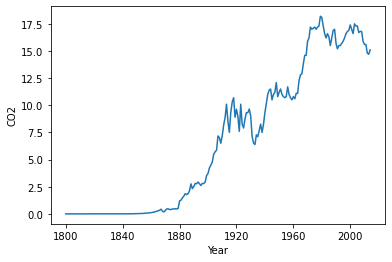

In [25]:
sns.lineplot(x='Year',y='CO2',data=fd)

<AxesSubplot:>

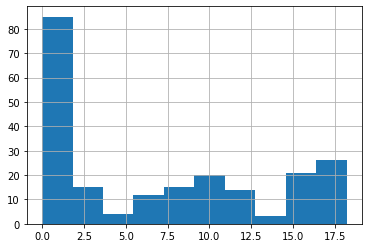

In [26]:
fd['CO2'].hist()

<AxesSubplot:ylabel='Density'>

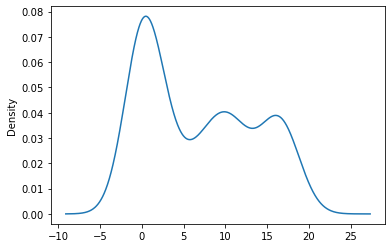

In [27]:
fd['CO2'].plot(kind='kde')

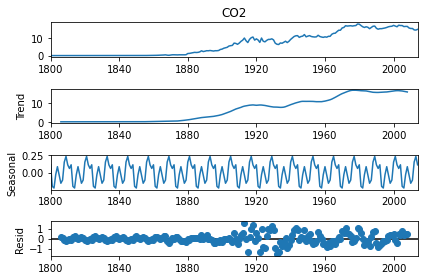

In [28]:
dec=seasonal_decompose(fd.CO2,period=12)
dec.plot()
plt.show()

In [29]:
fd['CO2'].describe()

count    215.000000
mean       6.741970
std        6.522437
min        0.001750
25%        0.041050
50%        6.390000
75%       11.500000
max       18.200000
Name: CO2, dtype: float64

In [30]:
X = fd.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.888644, mean2=12.650000
variance1=2.399437, variance2=13.176064


# ADFuller Test

In [31]:
def TestStationaryPlot(fd):
    rol_mean = fd.rolling(window = 20, center = False).mean()
    rol_std = fd.rolling(window = 20, center = False).std()
    
    plt.plot(fd, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

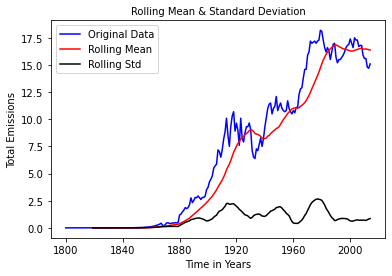

In [32]:
TestStationaryPlot(fd)

In [33]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(fd, cutoff = 0.01):
    fd_test = adfuller(fd, autolag = 'AIC')
    fd_test_output = pd.Series(fd_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    
    for key,value in fd_test[4].items():
        fd_test_output['Critical Value (%s)'%key] = value
    print(fd_test_output)
    
    if fd_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

In [34]:
TestStationaryAdfuller(fd)

Test Statistic                  -0.378463
p-value                          0.913633
Lags Used                        0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


# Transforming Data into Stationary

# A) Moving Average Method

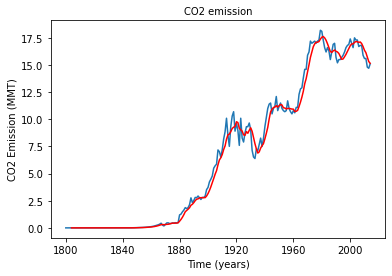

In [35]:
moving_avg = fd.rolling(5).mean()
plt.plot(fd)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [36]:
moving_avg_diff = fd - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,NaN
1803-01-01,NaN
1804-01-01,-0.000128
1805-01-01,-0.000124
1806-01-01,-0.000130
1807-01-01,-0.000126
1808-01-01,-0.000124


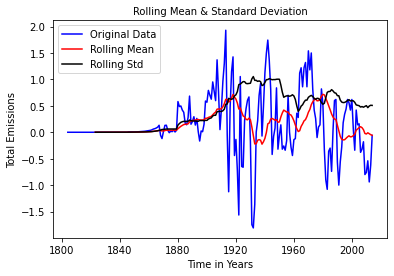

In [37]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [38]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.944115
p-value                          0.001733
Lags Used                        4.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Failed to reject null hypothesis. Data is stationary


# First Order Diferencing

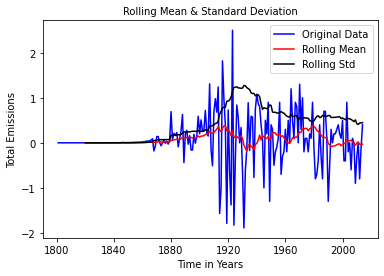

In [39]:
fd_first_difference = fd - fd.shift(1)  
TestStationaryPlot(fd_first_difference.dropna(inplace=False))

In [40]:
TestStationaryAdfuller(fd_first_difference.dropna(inplace=False))

Test Statistic                  -3.780005
p-value                          0.003119
Lags Used                       15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


In [41]:
# Trend & Seasonality Plot

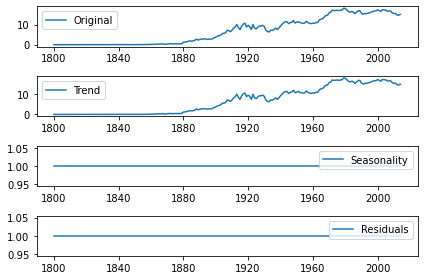

In [42]:
decomposition = seasonal_decompose(fd,period=1,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(fd, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ACF & PACF Plots

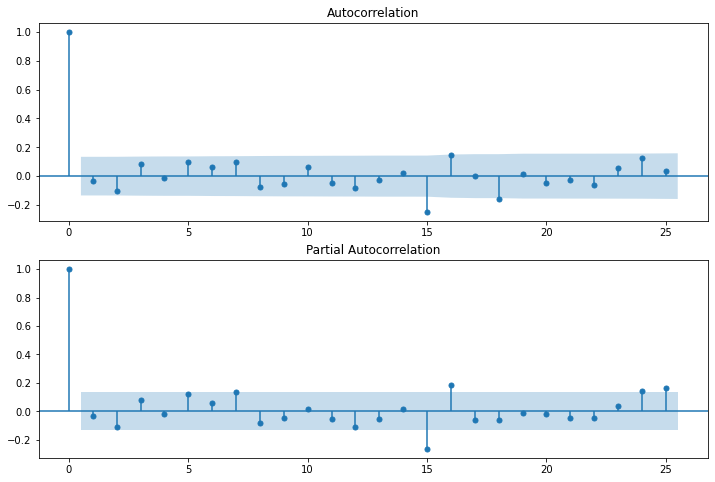

In [43]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fd_first_difference.dropna(inplace=False), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fd_first_difference.dropna(inplace=False), lags=25, ax=ax2)

# Data Partitioning

In [44]:
train = fd.iloc[:-30]
test = fd.iloc[-30:]

In [45]:
train

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542
...,...
1980-01-01,18.10000
1981-01-01,17.30000
1982-01-01,16.60000


In [46]:
test

,CO2
Year,
1985-01-01,16.3
1986-01-01,15.5
1987-01-01,16.2
1988-01-01,16.9
1989-01-01,17.0
1990-01-01,15.7
1991-01-01,15.2
1992-01-01,15.5
1993-01-01,15.5


In [47]:
# from First order Differencing we consider d=1 & from ACF & PACF plots we consider p=7 or 15 & q=2

# ARIMA Model

# ARIMA (7,1,2)

In [48]:
model_arima = ARIMA(train['CO2'],order = (7,1,2))
model_arima = model_arima.fit()
model_arima.summary()

C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  185
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -141.278
Date:                Sun, 27 Nov 2022   AIC                            302.557
Time:                        20:47:31   BIC                            334.706
Sample:                    01-01-1800   HQIC                           315.587
                         - 01-01-1984                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2858      0.052     -5.547      0.000      -0.387      -0.185
ar.L2         -0.9534      0.062    -15.348      0.000      -1.075      -0.832
ar.L3          0.0521      0.070      0.740      0.459      -0.086       0.190
ar.L4         -0.0465      0.074     -0.628      0.530      -0.191       0.098
ar.L5          0.2331      0.078      2.982      0.003       0.080       0.386
ar.L6          0.1401      0.055      2.558      0.011       0.033       0.248
ar.L7          0.1826      0.059      3.087      0.002       0.067       0.298
ma.L1          0.2612      0.024     10.893      0.000       0.214       0.308
ma.L2          0.9945      0.104      9.559      0.000       0.791       1.198
sigma2         0.2651      0.032      8.399      0.000       0.203       0.327
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                47.93
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):           18292.39   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

1985-01-01    16.676709
1986-01-01    16.309054
1987-01-01    16.086889
1988-01-01    16.148927
1989-01-01    16.229680
1990-01-01    16.153883
1991-01-01    16.110189
1992-01-01    16.106958
1993-01-01    16.058045
1994-01-01    16.063311
1995-01-01    16.115277
1996-01-01    16.086940
1997-01-01    16.027329
1998-01-01    16.054014
1999-01-01    16.093112
2000-01-01    16.058629
2001-01-01    16.037008
2002-01-01    16.068480
2003-01-01    16.069178
2004-01-01    16.041420
2005-01-01    16.053646
2006-01-01    16.072455
2007-01-01    16.051955
2008-01-01    16.042435
2009-01-01    16.064485
2010-01-01    16.064404
2011-01-01    16.044892
2012-01-01    16.052227
2013-01-01    16.066046
2014-01-01    16.054154
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [50]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 'rmse':rmse})

In [51]:
ns_arima_acc = forecast_accuracy(pred_arima.values, test.values)
ns_arima_acc

{'mape': 0.043699840324953006,
 'me': -0.12794228464883559,
 'mae': 0.7098813434224118,
 'rmse': 0.8094699221743098}

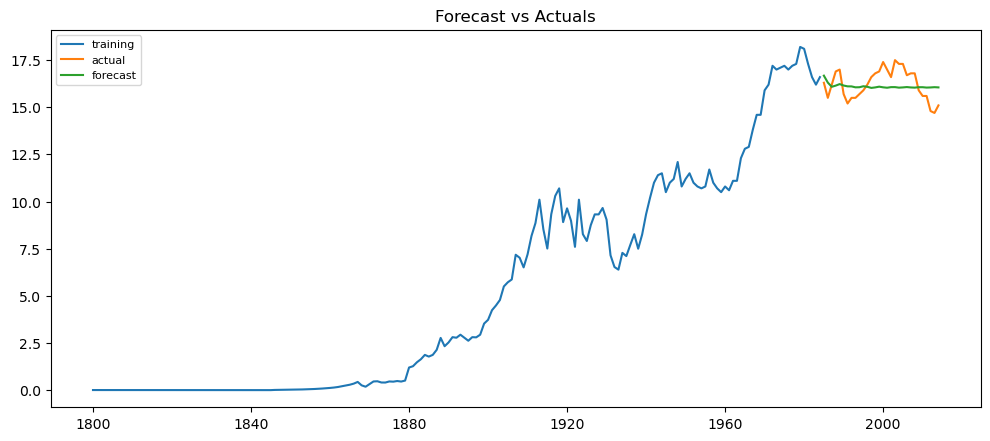

In [52]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# ARIMA (15,1,2)

In [53]:
Model_arima = ARIMA(train['CO2'],order = (15,1,2))
Model_arima = Model_arima.fit()
Model_arima.summary()

C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  185
Model:                ARIMA(15, 1, 2)   Log Likelihood                -135.234
Date:                Sun, 27 Nov 2022   AIC                            306.468
Time:                        20:47:36   BIC                            364.337
Sample:                    01-01-1800   HQIC                           329.923
                         - 01-01-1984                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7324      0.358     -2.045      0.041      -1.434      -0.030
ar.L2         -0.3337      0.282     -1.183      0.237      -0.887       0.219
ar.L3          0.0304      0.071      0.426      0.670      -0.109       0.170
ar.L4          0.0184      0.076      0.242      0.809      -0.131       0.167
ar.L5          0.1920      0.073      2.648      0.008       0.050       0.334
ar.L6          0.2796      0.094      2.962      0.003       0.095       0.465
ar.L7          0.3097      0.123      2.508      0.012       0.068       0.552
ar.L8          0.0863      0.110      0.782      0.434      -0.130       0.302
ar.L9         -0.0653      0.076     -0.861      0.389      -0.214       0.083
ar.L10        -0.0134      0.096     -0.139      0.889      -0.202       0.176
ar.L11        -0.0601      0.073     -0.822      0.411      -0.203       0.083
ar.L12        -0.0986      0.086     -1.143      0.253      -0.268       0.070
ar.L13        -0.1020      0.095     -1.075      0.282      -0.288       0.084
ar.L14         0.0631      0.081      0.777      0.437      -0.096       0.222
ar.L15        -0.1606      0.087     -1.842      0.066      -0.332       0.010
ma.L1          0.7501      0.375      2.002      0.045       0.016       1.484
ma.L2          0.2665      0.300      0.888      0.375      -0.322       0.855
sigma2         0.2517      0.022     11.360      0.000       0.208       0.295
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                46.80
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):           18639.70   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
start = len(train)
end = len(train)+len(test)-1
Pred_arima = Model_arima.predict(start=start,end=end)
print(Pred_arima)

1985-01-01    16.381060
1986-01-01    16.505662
1987-01-01    15.990366
1988-01-01    15.773787
1989-01-01    15.762697
1990-01-01    15.655807
1991-01-01    15.782083
1992-01-01    15.599396
1993-01-01    15.672710
1994-01-01    15.503040
1995-01-01    15.511620
1996-01-01    15.663889
1997-01-01    15.593387
1998-01-01    15.718355
1999-01-01    15.577550
2000-01-01    15.711548
2001-01-01    15.635640
2002-01-01    15.732427
2003-01-01    15.794147
2004-01-01    15.713478
2005-01-01    15.809169
2006-01-01    15.739214
2007-01-01    15.817962
2008-01-01    15.785423
2009-01-01    15.812637
2010-01-01    15.842677
2011-01-01    15.764595
2012-01-01    15.849819
2013-01-01    15.780717
2014-01-01    15.835938
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [55]:
Ns_arima_acc = forecast_accuracy(Pred_arima.values, test.values)
Ns_arima_acc

{'mape': 0.047132707443110905,
 'me': -0.45610681308175116,
 'mae': 0.7790024287620013,
 'rmse': 0.9354304962362929}

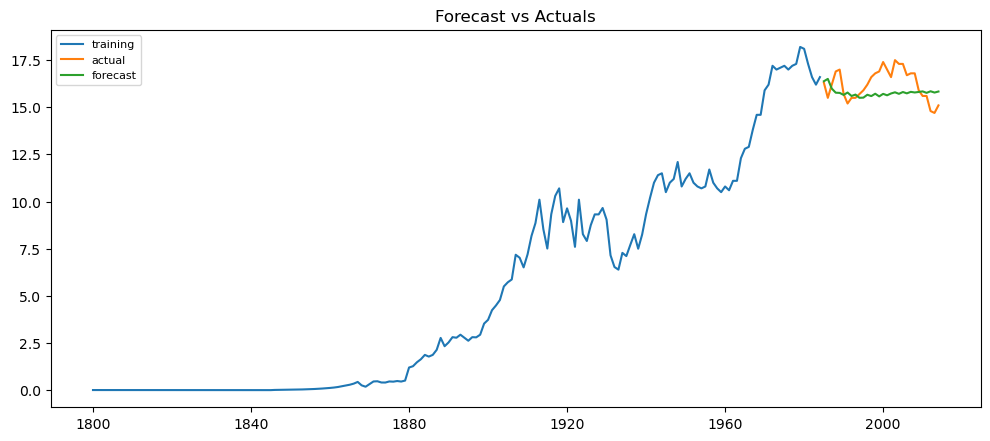

In [56]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(Pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Smoothing Technique Methods

In [57]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Simple Exponential Smoothing

In [58]:
SES = SimpleExpSmoothing(train['CO2']).fit(smoothing_level = 0.2)

C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [59]:
pred_ses = SES.predict(start = len(train),end = len(train)+len(test)-1)

In [60]:
ns_ses_acc = forecast_accuracy(pred_ses,test.CO2)
ns_ses_acc

{'mape': 0.049107630736273146,
 'me': 0.5841799936131596,
 'mae': 0.7681728859083632,
 'rmse': 0.9825927371806151}

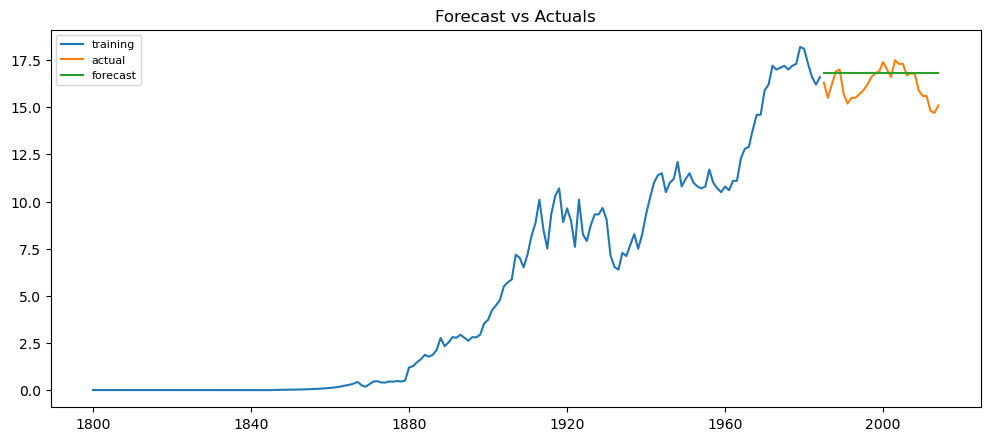

In [61]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Holt's Method

In [62]:
HLT= Holt(train["CO2"]).fit(smoothing_level=0.8, smoothing_slope=0.2)

C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\AppData\Local\Temp/ipykernel_15780/2930083788.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  HLT= Holt(train["CO2"]).fit(smoothing_level=0.8, smoothing_slope=0.2)


In [63]:
pred_holt = HLT.predict(start = len(train),end = len(train)+len(test)-1)

In [64]:
ns_hlt_acc = forecast_accuracy(pred_holt,test.CO2)
ns_hlt_acc

{'mape': 0.07779354357980446,
 'me': -1.126283548897267,
 'mae': 1.2864199244934367,
 'rmse': 1.539987532503777}

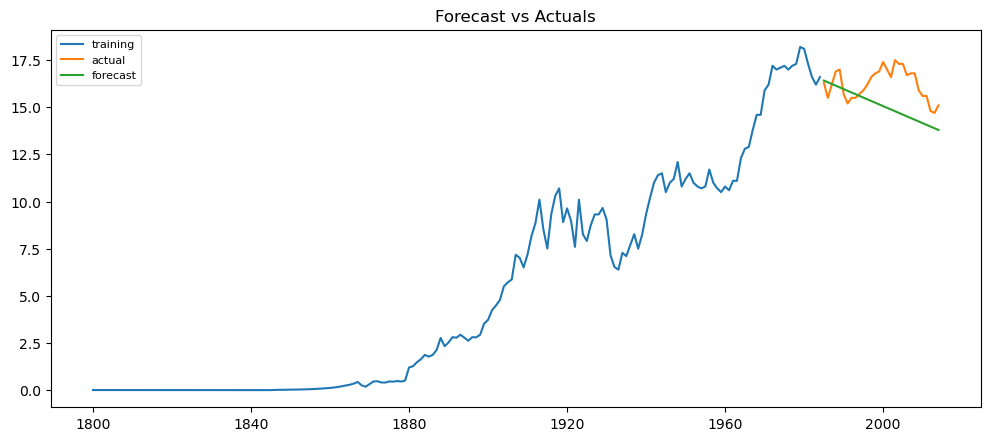

In [65]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Holt-Winter Method

In [66]:
HLW = ExponentialSmoothing(train['CO2'],seasonal='add',trend='add',seasonal_periods=2).fit()

C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [67]:
pred_hlw=HLW.predict(start = len(train),end = len(train)+len(test)-1)

In [68]:
ns_hlw_acc = forecast_accuracy(pred_hlw,test.CO2)
ns_hlw_acc

{'mape': 0.10945729076140447,
 'me': 1.728416792147442,
 'mae': 1.72869461361204,
 'rmse': 2.0874445423090524}

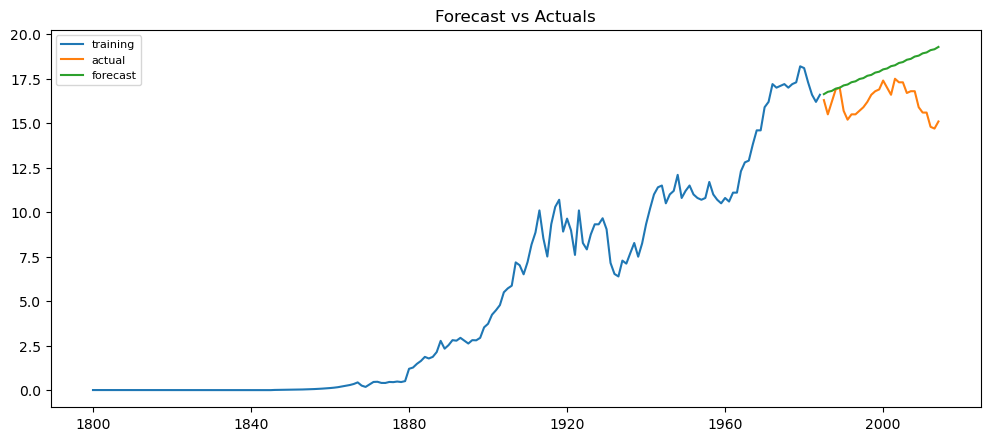

In [69]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hlw, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Modelwise Errors

In [70]:
data = {"MODEL":pd.Series(["ARIMA(7,1,2)","ARIMA(15,1,2)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],Ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],Ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],Ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],Ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
0,"ARIMA(7,1,2)",0.809470,0.043700,-0.127942,0.709881
1,"ARIMA(15,1,2)",0.935430,0.047133,-0.456107,0.779002
2,Simple exponential smoothing,0.982593,0.049108,0.584180,0.768173
3,Holt Method,1.539988,0.077794,-1.126284,1.286420
4,Holt-Winter Method,2.087445,0.109457,1.728417,1.728695


In [71]:
tata = {"MODEL":pd.Series(["ARIMA(7,1,2)","ARIMA(15,1,2)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],Ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],Ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],Ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],Ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_mape=pd.DataFrame(tata)
table_mape.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
0,"ARIMA(7,1,2)",0.809470,0.043700,-0.127942,0.709881
1,"ARIMA(15,1,2)",0.935430,0.047133,-0.456107,0.779002
2,Simple exponential smoothing,0.982593,0.049108,0.584180,0.768173
3,Holt Method,1.539988,0.077794,-1.126284,1.286420
4,Holt-Winter Method,2.087445,0.109457,1.728417,1.728695


# Final Model

In [72]:
final_arima = ARIMA(fd['CO2'],order = (7,1,2))
final_arima = final_arima.fit()
final_arima.summary()

C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
C:\Users\Shraddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  215
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -167.416
Date:                Sun, 27 Nov 2022   AIC                            354.832
Time:                        20:47:56   BIC                            388.492
Sample:                    01-01-1800   HQIC                           368.434
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5400      0.113     -4.785      0.000      -0.761      -0.319
ar.L2         -0.8673      0.098     -8.857      0.000      -1.059      -0.675
ar.L3          0.0400      0.067      0.596      0.551      -0.091       0.171
ar.L4         -0.0226      0.072     -0.314      0.754      -0.164       0.119
ar.L5          0.2305      0.071      3.230      0.001       0.091       0.370
ar.L6          0.1311      0.056      2.353      0.019       0.022       0.240
ar.L7          0.2396      0.052      4.607      0.000       0.138       0.342
ma.L1          0.5282      0.102      5.161      0.000       0.328       0.729
ma.L2          0.7805      0.092      8.460      0.000       0.600       0.961
sigma2         0.2791      0.022     12.522      0.000       0.235       0.323
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                36.88
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):             267.66   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
final_arima.fittedvalues.tail()

Year
2010-01-01    16.043048
2011-01-01    15.467934
2012-01-01    15.492598
2013-01-01    14.846897
2014-01-01    14.653038
dtype: float64

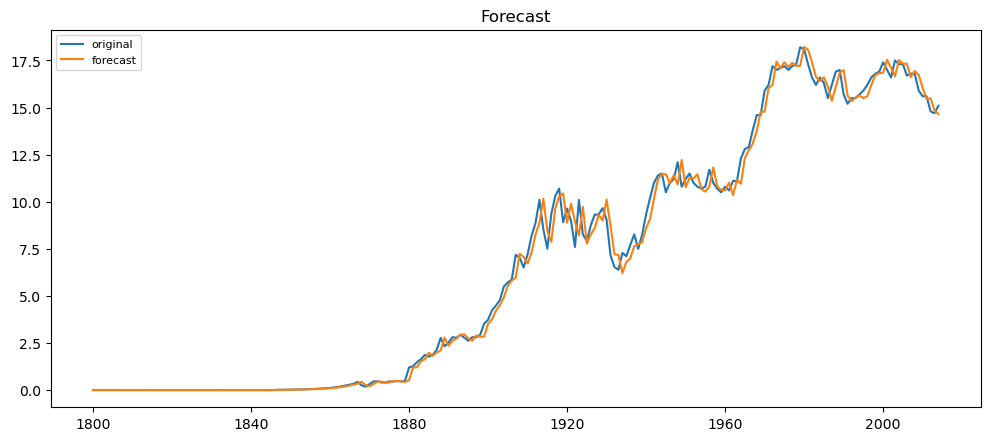

In [74]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fd, label='original')

plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [75]:
future_dates=[fd.index[-1]+ DateOffset(years=x)for x in range(0,9)]

In [76]:
future_df=pd.DataFrame(index=future_dates[1:],columns=fd.columns)
future_df

,CO2
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN


In [77]:
future_df['CO2'] = final_arima.predict(start = 215, end = 222, dynamic= True)

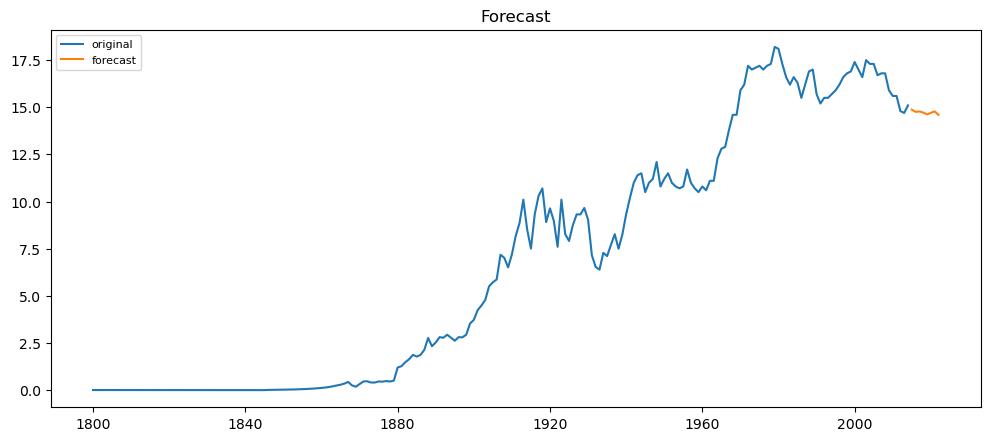

In [78]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fd, label='original')

plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [79]:
future_df

,CO2
2015-01-01,14.873109
2016-01-01,14.756640
2017-01-01,14.778315
2018-01-01,14.721607
2019-01-01,14.621282
2020-01-01,14.704324
2021-01-01,14.783006
2022-01-01,14.601129
